In [2]:
# Importing the relevant packages
import pandas
from pandas import DataFrame
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split

In [3]:
# For loading the data
train_data_path: str = "~/Desktop/spaceship_titanic/data/train.csv"
train_data: DataFrame = pandas.read_csv(train_data_path)

## Notes
- PassengerId: Must be split into group number and group member
- HomePlanet: Is class variable with 3 classes
- CryoSleep: Is boolean variable
- Cabin: Must be split into three class variables
- Age: A numeric variable
- VIP: A boolean variable
- RoomService: Numeric, predominantly 0
- FoodCourt: Numeric, predominantly 0
- ShoppingMall: Numeric, predominantly 0
- Spa: Numeric, predominantly 0
- VRDeck: Numeric, predominantly 0
- Name: Purely ID based (Can be used for identifying families)
- Transported: Boolean variable

In [4]:
train_data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


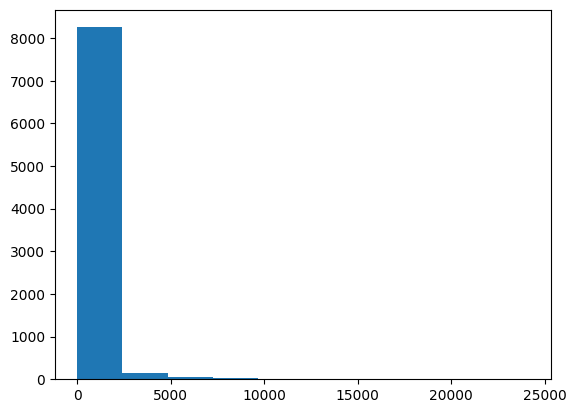

True     4378
False    4315
Name: Transported, dtype: int64

In [5]:
# Code for analysing features

# For showing number of unique entries
train_data.nunique()

# For showing histograms of different columns
plt.hist(train_data["VRDeck"])
plt.show()

# For showing the counts of unique values in a column
train_data["Transported"].value_counts().sort_values(ascending=False)

In [6]:
# Section for modifying dataset
edit_data = copy.deepcopy(train_data)

# PassengerID removed, as predictions are made per individual rather than per group
edit_data[["Deck", "Num", "Side"]] = edit_data["Cabin"].str.split("/", expand = True)

edit_data = edit_data.drop(["Cabin", "Num", "PassengerId", "Name"], axis=1)

numeric_list: list = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
mod_list: list = [i + "IsZero" for i in numeric_list]

edit_data[mod_list] = edit_data[numeric_list].apply(lambda x: x == 0.0)

edit_data = pandas.get_dummies(edit_data, drop_first=True, dummy_na=True)

for i in (numeric_list + ["Age"]):
    edit_data[i + "IsNaN"] = edit_data[i].isna()
    edit_data[i] = edit_data[i].fillna(0)

In [51]:
import numpy

subject = "Transported"

y = copy.deepcopy(edit_data[subject])
X = copy.deepcopy(edit_data.drop([subject], axis=1))

In [60]:
proportion_trained = 0.75
cutoff = int(proportion_trained * len(X))

X_train = X.iloc[:cutoff]
X_val = X.iloc[cutoff:]
y_train = y.iloc[:cutoff]
y_val = y.iloc[cutoff:]

In [52]:
from torch.utils.data import Dataset, DataLoader
import torch

class SpaceData(Dataset):

    def __init__(self, X, y):

        X = copy.deepcopy(X).to_numpy(dtype=float)
        self.X = torch.tensor(X, dtype=torch.float)

        y = copy.deepcopy(y).to_numpy(dtype=float)
        self.y = torch.reshape(torch.tensor(y, dtype=torch.float), (-1,1))

    def __len__(self):

        return len(self.X)

    def __getitem__(self, index):
        return self.X[index, :], self.y[index]

space_train_dataset = SpaceData(X=X_train,y=y_train)
space_val_dataset = SpaceData(X=X_val,y=y_val)

space_train_dataloader = DataLoader(dataset=space_train_dataset, batch_size=len(space_train_dataset), shuffle=True)
space_val_dataloader = DataLoader(dataset=space_val_dataset, batch_size=len(space_val_dataset), shuffle=True)

Now's the time to get out the big guns (PyTorch)

In [53]:
import torch

class CustomModel(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.LazyLinear(50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input=input)

custom_model = CustomModel()

loss_model = torch.nn.BCELoss()

optimiser = torch.optim.SGD(custom_model.parameters(), lr=10**(-4))

/home/seelmath/miniconda3/envs/spaceship/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [56]:
def loss_calulation(dataloader, custom_model, loss_model, no_grad=False):

    for (sample, label) in dataloader:

        if not no_grad:
            prediction = custom_model(sample)
            return loss_model(prediction, label)
        else:
            with torch.no_grad:
                prediction = custom_model(sample)
                return loss_model(prediction, label)

def optimise():
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()


size = 100
for current in range(size):
    for (sample,label) in space_train_dataloader:


        prediction = custom_model(sample)
        loss = loss_model(prediction, label)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        (val)
        val_prediction

        print(f"loss: {loss.item():>7f}  [{current+1:>5d}/{size:>5d}]")

loss: 0.792740  [    1/  100]
loss: 0.791765  [    2/  100]
loss: 0.790818  [    3/  100]
loss: 0.789907  [    4/  100]
loss: 0.789065  [    5/  100]
loss: 0.788256  [    6/  100]
loss: 0.787455  [    7/  100]
loss: 0.786669  [    8/  100]
loss: 0.785897  [    9/  100]
loss: 0.785125  [   10/  100]
loss: 0.784340  [   11/  100]
loss: 0.783574  [   12/  100]
loss: 0.782811  [   13/  100]
loss: 0.782053  [   14/  100]
loss: 0.781313  [   15/  100]
loss: 0.780577  [   16/  100]
loss: 0.779860  [   17/  100]
loss: 0.779153  [   18/  100]
loss: 0.778454  [   19/  100]
loss: 0.777765  [   20/  100]
loss: 0.777078  [   21/  100]
loss: 0.776403  [   22/  100]
loss: 0.775733  [   23/  100]
loss: 0.775071  [   24/  100]
loss: 0.774415  [   25/  100]
loss: 0.773764  [   26/  100]
loss: 0.773126  [   27/  100]
loss: 0.772494  [   28/  100]
loss: 0.771865  [   29/  100]
loss: 0.771243  [   30/  100]
loss: 0.770622  [   31/  100]
loss: 0.770004  [   32/  100]
loss: 0.769392  [   33/  100]
loss: 0.76